In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

import timeit

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

In [87]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 6587, 3578, 745, 430
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 504

dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 150.0:
        del_list.append(i)
cut_xyzs = np.delete(xyzs,del_list,axis=0)


In [88]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

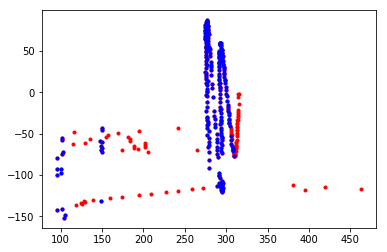

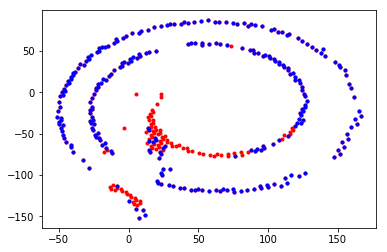

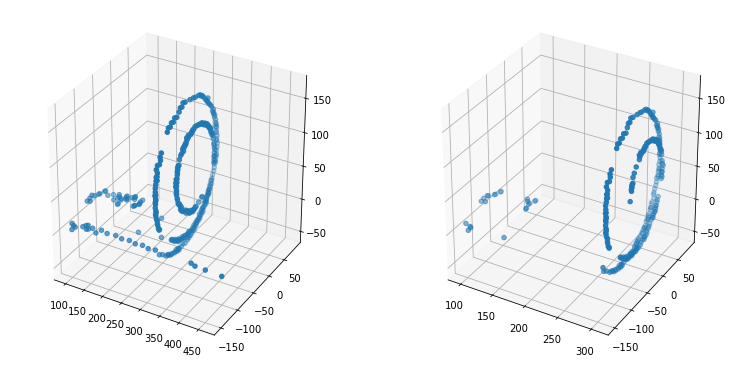

In [89]:
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0])
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0])

<IPython.core.display.Javascript object>


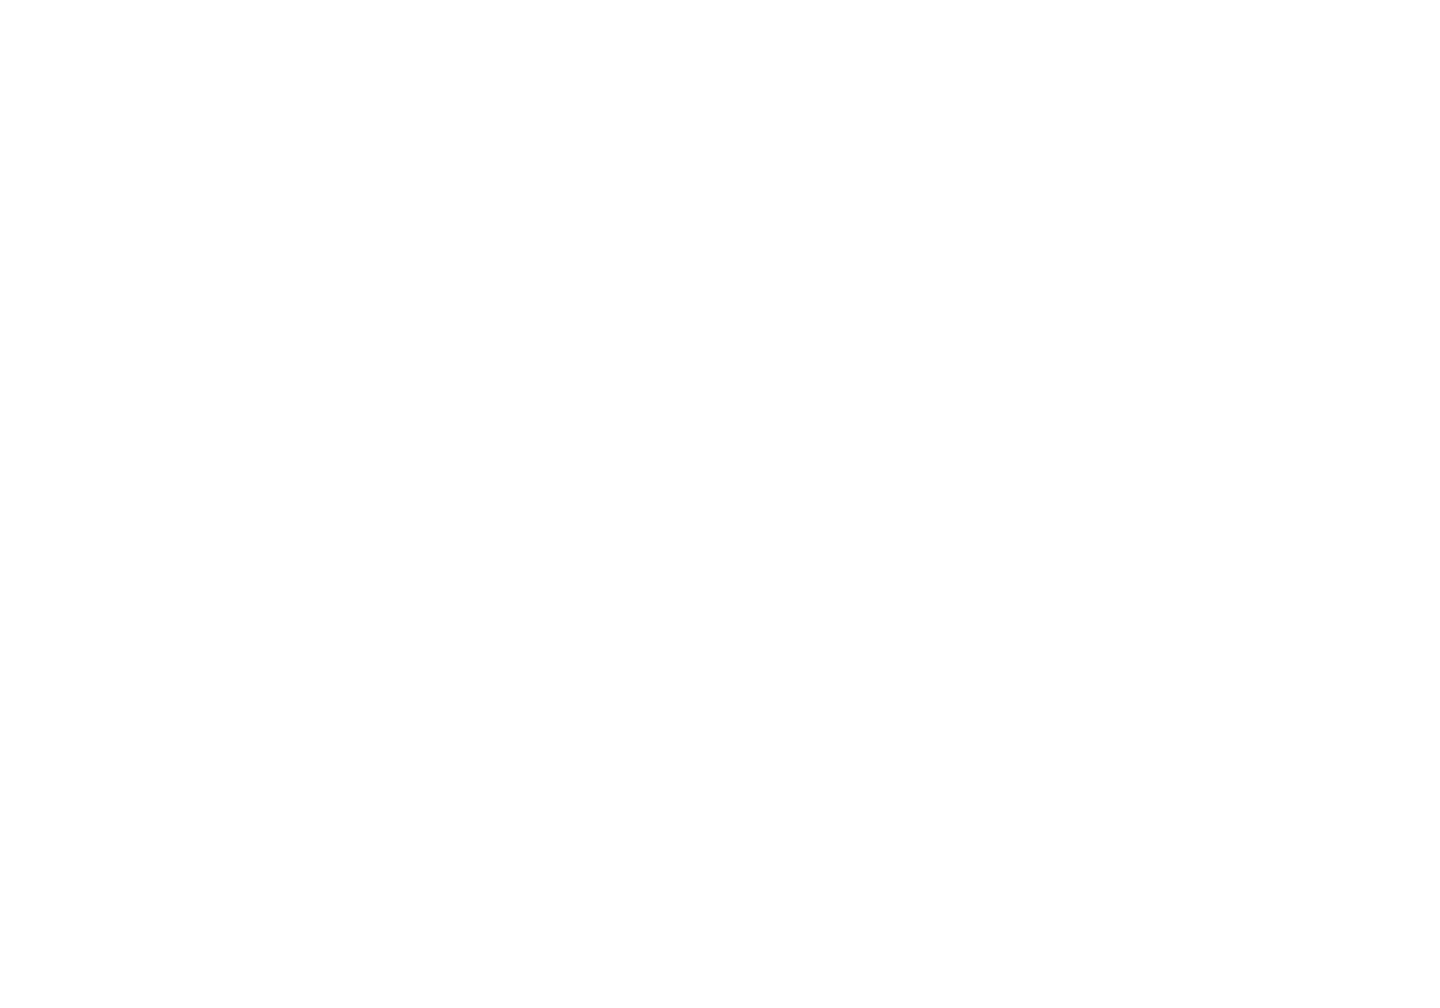

<IPython.core.display.Javascript object>


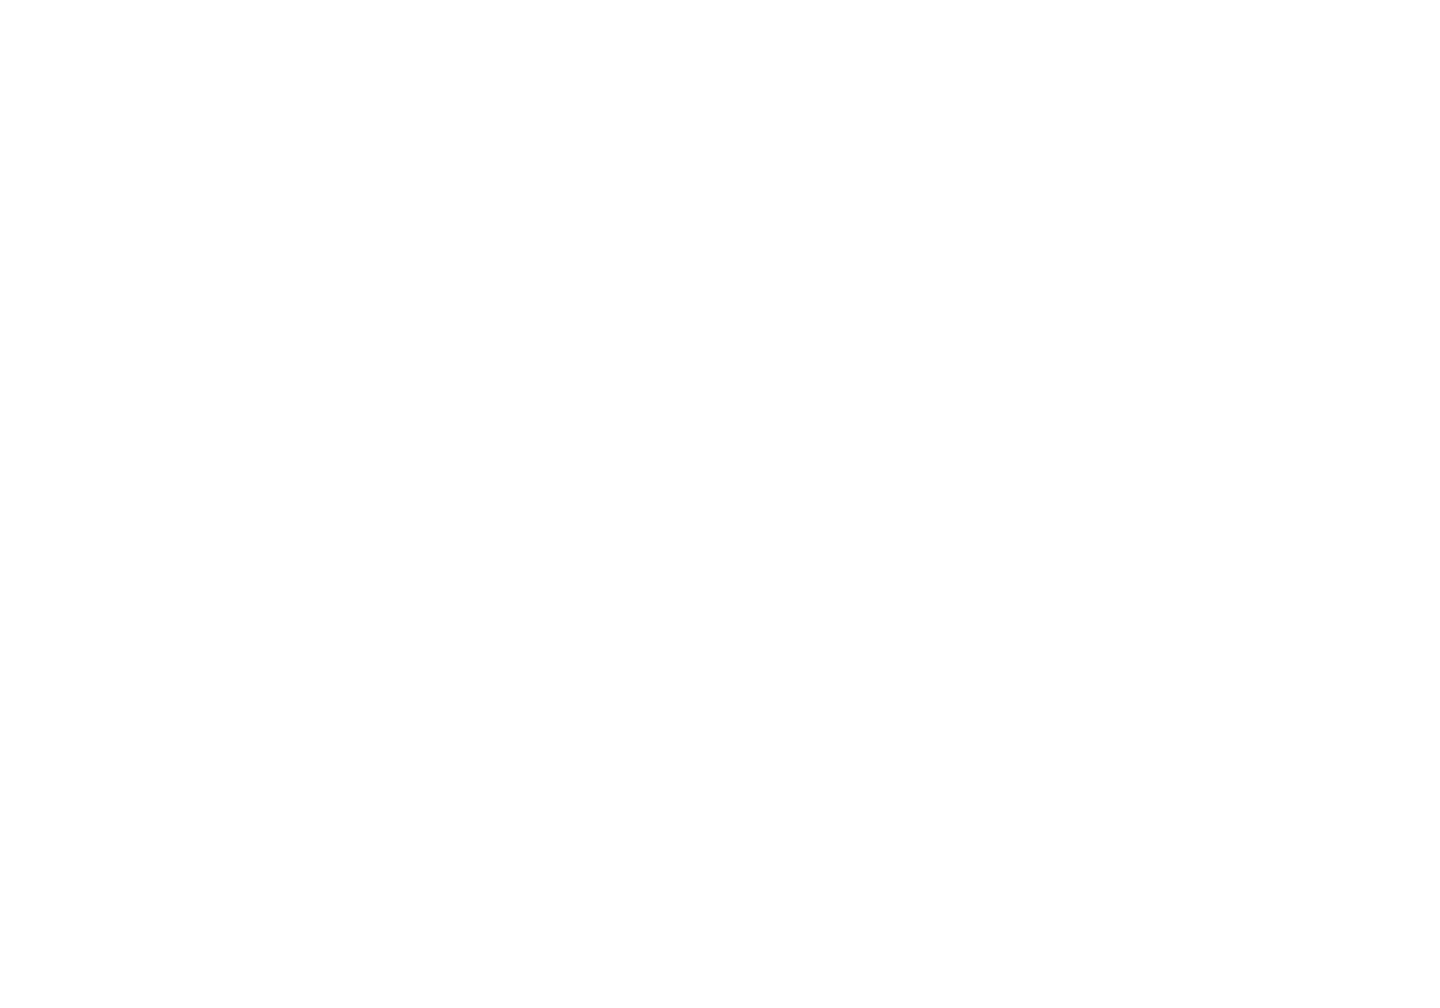

In [90]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(xyzs[:,2],xyzs[:,1],xyzs[:,0], c='r', label='original data')
ax.scatter(cut_xyzs[:,2],cut_xyzs[:,1],cut_xyzs[:,0], c='b', label='after cut')


In [91]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False) # get calibrated set of data
cut_uvw_values = cut_uvw.values

In [92]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [93]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [94]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

Conjugate Gradient

In [95]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)


In [96]:
def cut_f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, cut_exp_pos, cut_exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def cut_jacobian(x):
    return scipy.optimize.approx_fprime(x,cut_f,eps)

In [97]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1   
     

In [98]:
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':eps})    
cg = results.x
print(results)

     fun: 101.05753063640873
     jac: array([ -30.04810333,  -13.93453598, -459.58883858,    2.36824894,
          1.97718334,   32.22126865])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 71
     nit: 0
    njev: 61
  status: 2
 success: False
       x: array([ 0.        ,  0.        ,  0.63667047,  0.41177385, -3.83958732,
        1.6436828 ])


In [99]:
j = 1    
def cut_callbackF(x):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    j += 1  

In [28]:
cut_results = scipy.optimize.minimize(cut_f, cut_ctr0, method="CG", jac=cut_jacobian, callback=cut_callbackF, options={'gtol': 30.0, 'eps':1e-13})    
cut_cg = cut_results.x
print(cut_results)

   1 0.010038 0.003022 0.675508 2.377409-2.049902 1.793252 95.230111
   2 0.008424 0.002585 0.673623 2.377414-2.050003 1.794322 95.024766
   3 0.003039-0.000087 0.675837 2.377328-2.050206 1.794783 94.040075
   4-0.000846-0.001342 0.676068 2.377381-2.050707 1.799467 93.590308
   5 0.002006-0.001074 0.677222 2.377425-2.051090 1.803738 92.962026
   6 0.003779-0.003874 0.684847 2.377381-2.051216 1.809094 92.059103
   7 0.008129-0.005236 0.701216 2.377465-2.051894 1.826960 91.477511
   8 0.011526-0.004957 0.715384 2.377679-2.052636 1.846472 87.524522
   9 0.009378-0.001197 0.722171 2.378090-2.053253 1.861706 82.163079
  10-0.003786 0.005210 0.720625 2.378463-2.053535 1.862467 78.445334
  11-0.004283 0.005213 0.721256 2.378503-2.053594 1.862408 78.345720
  12-0.004452 0.005133 0.721659 2.378827-2.053633 1.862395 78.171361
  13-0.002021 0.003146 0.721598 2.379085-2.053803 1.863901 77.896023
  14-0.001464 0.002572 0.722424 2.379197-2.053920 1.864192 77.693727
  15-0.001753 0.002898 0.722899 2.

In [29]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [30]:
cut_evtClean, cut_ctr = sim.make_event(cut_cg[0], cut_cg[1], cut_cg[2], cut_cg[3], cut_cg[4], cut_cg[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


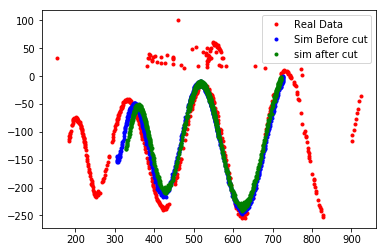

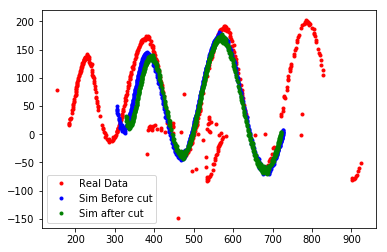

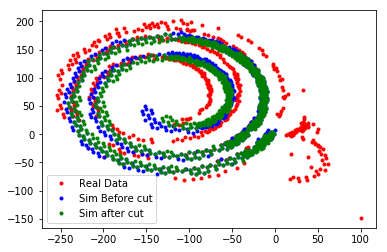

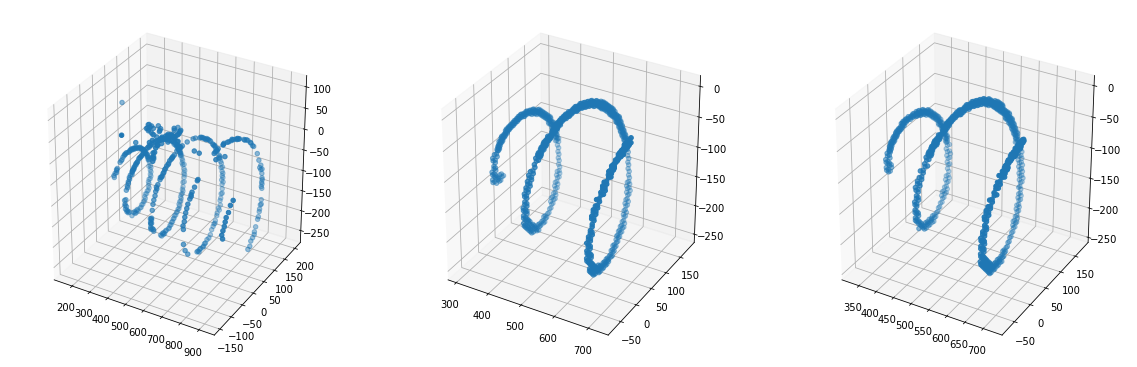

In [31]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])

<IPython.core.display.Javascript object>


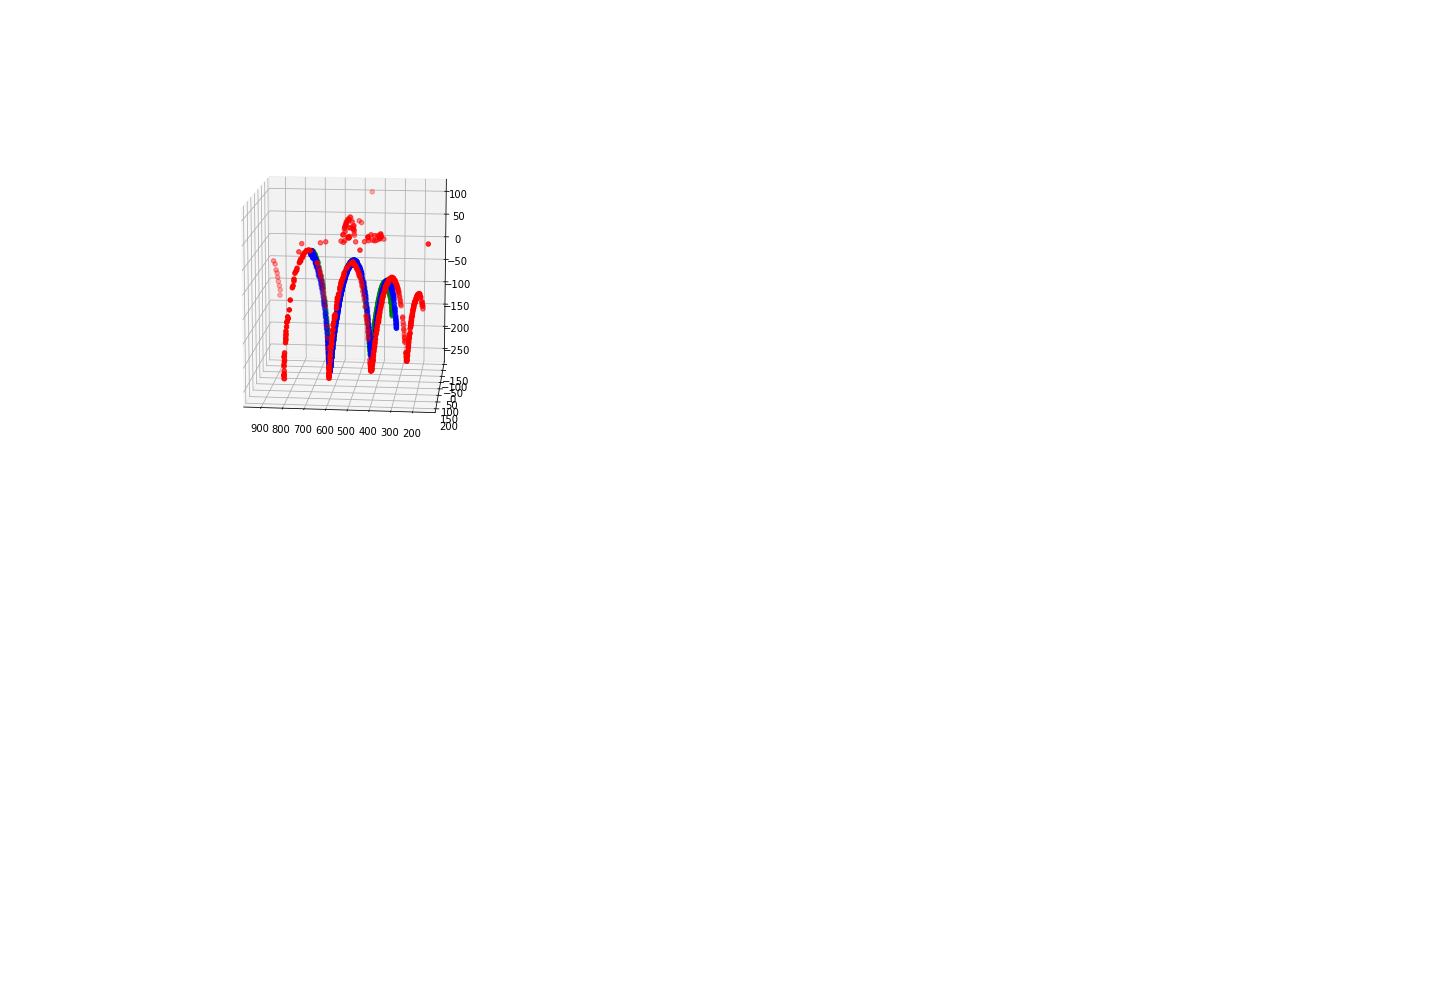

In [32]:
%matplotlib notebook
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')


In [100]:
scipy.optimize.fmin_bfgs(cut_f, cut_ctr0, fprime=cut_jacobian, callback=cut_callbackF)

   1-0.000075-0.000031 0.578841 0.839791-3.760506 1.471811 88.304055
   2 0.003683 0.001540 0.579447 0.839926-3.760705 1.472606 87.929714
   3 0.003341 0.002885 0.579712 0.840256-3.760988 1.474096 87.884274
   4 0.003262 0.002920 0.580149 0.840875-3.761539 1.476843 87.800164
   5 0.002932 0.007448 0.584211 1.148466-3.866166 1.504948 79.012523
   6 0.002686 0.008639 0.585122 1.221323-3.902466 1.510537 78.072210
   7 0.000702 0.009543 0.585364 1.227410-3.981038 1.508279 76.692775
   8-0.005906 0.009658 0.583091 1.522551-4.123024 1.497765 71.306775
   9-0.003338 0.000105 0.582504 1.354927-4.115581 1.493838 68.084425
  10 0.005860 0.001997 0.583493 1.323893-3.950569 1.499023 67.473715
  11 0.004684 0.002093 0.583214 1.346546-3.982198 1.497379 66.275222
  12 0.002510 0.002764 0.582882 1.365653-4.029907 1.496491 65.832339
  13 0.002484 0.001948 0.582640 1.362642-4.027330 1.495064 65.742955
  14 0.002435 0.001908 0.582533 1.360747-4.026053 1.494497 65.731074
  15 0.002470 0.001917 0.582518 1.

array([ 2.47107032e-03,  1.92068342e-03,  5.82517918e-01,  1.35898751e+00,
       -4.02648371e+00,  1.49435489e+00])

Differential Evolution

In [101]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]

In [111]:
%%time
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=1000, strategy='best1bin',\
                                                recombination=0.7, popsize=25, mutation=(0.5,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

 288-0.040732-0.023939 0.477316 1.182332 4.165670 0.143483 145.839212
 289 0.013380-0.021228 0.204937 4.877075 3.414919 2.489448 112.461945
 290 0.013380-0.021228 0.204937 4.877075 3.414919 2.489448 112.461945
 291 0.013380-0.021228 0.204937 4.877075 3.414919 2.489448 112.461945
 292-0.016160-0.003959 0.753706 3.327097 3.518254 3.555733 102.356113
 293-0.016160-0.003959 0.753706 3.327097 3.518254 3.555733 102.356113
 294-0.000506-0.006083 0.543774 0.916450-1.085904-2.281189 101.641293
 295-0.000506-0.002524 0.038228 4.271010-5.025445-0.590851 101.318220
 296-0.018514 0.003378 0.887362 3.362187 4.526195-2.495110 98.232317
 297 0.004864-0.008708 0.593308 4.090431 5.584156-3.134110 98.091410
 298-0.001636 0.004805 0.532184 4.261203 5.402161 5.641673 95.969521
 299 0.002306-0.003660 0.351345 3.676701-1.478182 5.945737 93.878944
 300-0.012759-0.010419 0.441329 2.622400-1.011844 5.571704 93.398910
 301-0.000916 0.010078 0.128160 2.846442 0.236463 5.913893 87.847000
 302-0.000916 0.010078 0.1

 407-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 408-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 409-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 410-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 411-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 412-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 413-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 414-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 415-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 416-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 417-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 418-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 419-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 420-0.004053 0.000814 0.183682 2.505993 0.551436 5.440319 83.063417
 421-0.004053 0.000814 0.183682 2.

 526-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 527-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 528-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 529-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 530-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 531-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 532-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 533-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 534-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 535-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 536-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 537-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 538-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 539-0.006420-0.001256 0.272225 2.132891-0.578262 5.039437 79.478814
 540-0.006420-0.001256 0.272225 2.

 645-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 646-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 647-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 648-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 649-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 650-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 651-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 652-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 653-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 654-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 655-0.002091-0.001221 0.342678 2.202842-0.595803 4.960155 72.751180
 656-0.008135-0.000854 0.368715 2.284245-0.627855 4.928400 70.417711
 657-0.008135-0.000854 0.368715 2.284245-0.627855 4.928400 70.417711
 658-0.008135-0.000854 0.368715 2.284245-0.627855 4.928400 70.417711
 659-0.008135-0.000854 0.368715 2.

In [112]:
results.fun #30.26455552871073 

65.16073703856351

In [113]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


[-2.21619759e-04 -2.79198573e-03  4.11878552e-01  2.32666691e+00
 -5.59849374e-01  4.88591745e+00]


In [114]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [115]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

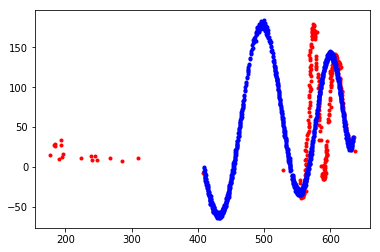

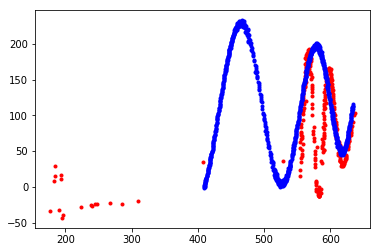

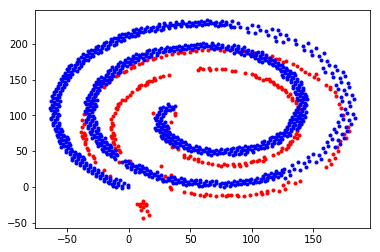

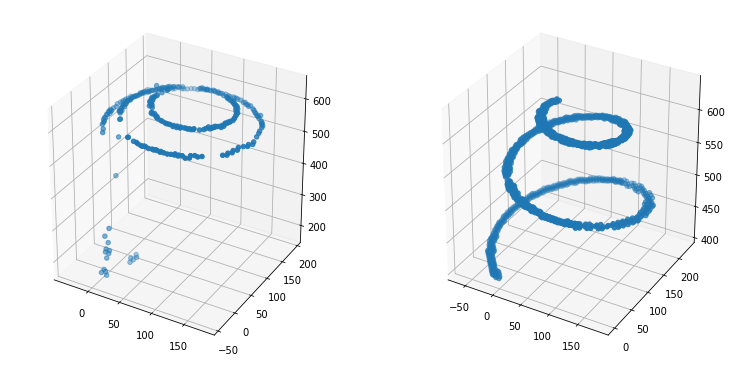

In [116]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [117]:
%%time
i = 1
def cut_callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],cut_f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(cut_f, bounds, callback=cut_callbackF, maxiter=1000, strategy='best1bin',\
                                                 recombination=0.7, popsize=15, mutation=(0.5,1.5))
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1-0.082315 0.070002 0.010219 2.743879 0.320226 0.138569 334.303968
   2-0.046209-0.006413 0.518546 4.111131 4.168351-1.284764 143.922813
   3 0.011796-0.028010 0.466103 0.909840 1.391744 1.878605 119.392362
   4 0.011796-0.028010 0.466103 0.909840 1.391744 1.878605 119.392362
   5 0.015158 0.022769 0.508947 2.300983 2.261370 4.933584 115.743349
   6-0.000244 0.008934 0.416052 3.568753 6.020177 3.264948 102.085972
   7 0.002904-0.010013 0.199942 1.475572 3.302286-2.724957 100.820786
   8 0.002904-0.010013 0.199942 1.475572 3.302286-2.724957 100.820786
   9 0.002904-0.010013 0.199942 1.475572 3.302286-2.724957 100.820786
  10 0.002904-0.010013 0.199942 1.475572 3.302286-2.724957 100.820786
  11 0.010350 0.005275 0.276279 3.522835 3.115156-5.119741 92.731626
  12 0.010350 0.005275 0.276279 3.522835 3.115156-5.119741 92.731626
  13-0.001230 0.014646 0.708305 4.137084 2.073138-3.918999 90.413788
  14-0.001230 0.014646 0.708305 4.137084 2.073138-3.918999 90.413788
  15-0.007474 0.015248 0

 121 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 122 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 123 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 124 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 125 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 126 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 127 0.002141 0.004375 0.182272 2.412432 0.303422-0.579560 82.492222
 128 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 129 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 130 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 131 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 132 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 133 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 134 0.003513 0.004375 0.525149 1.351567-0.684343-1.304098 77.862195
 135 0.003513 0.004375 0.525149 1.

 241-0.005973-0.000981 0.553119 2.050602-0.800717-1.521195 44.134089
 242-0.003888-0.003967 0.551878 1.911622-0.743889-1.517377 42.839094
 243-0.010136-0.003934 0.552427 2.030007-0.759647-1.520423 42.686819
 244-0.010136-0.003934 0.552427 2.030007-0.759647-1.520423 42.686819
 245-0.004197-0.000800 0.552249 1.983960-0.754346-1.519328 42.504781
 246-0.004197-0.000800 0.552249 1.983960-0.754346-1.519328 42.504781
 247-0.003043-0.004843 0.552529 2.036792-0.742997-1.520789 42.383139
 248-0.003043-0.004843 0.552529 2.036792-0.742997-1.520789 42.383139
 249-0.003043-0.004843 0.552529 2.036792-0.742997-1.520789 42.383139
 250-0.001570-0.004390 0.551981 1.969962-0.700677-1.519023 42.120883
 251-0.001570-0.004390 0.551981 1.969962-0.700677-1.519023 42.120883
 252-0.001570-0.004390 0.551981 1.969962-0.700677-1.519023 42.120883
 253-0.004735-0.004398 0.552046 1.999979-0.739773-1.519267 41.991791
 254-0.004735-0.004398 0.552046 1.999979-0.739773-1.519267 41.991791
 255-0.004735-0.004398 0.552046 1.

In [118]:
cut_dfe = results.x

In [119]:
cut_evtClean, cut_ctr = sim.make_event(cut_dfe[0], cut_dfe[1], cut_dfe[2], cut_dfe[3], cut_dfe[4], cut_dfe[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [120]:
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

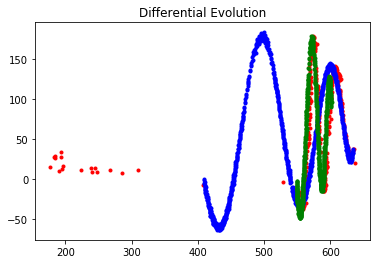

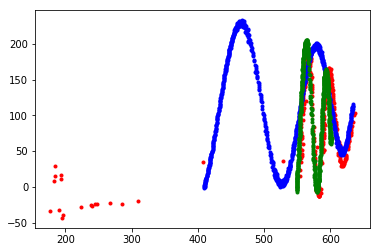

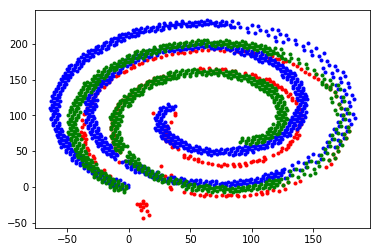

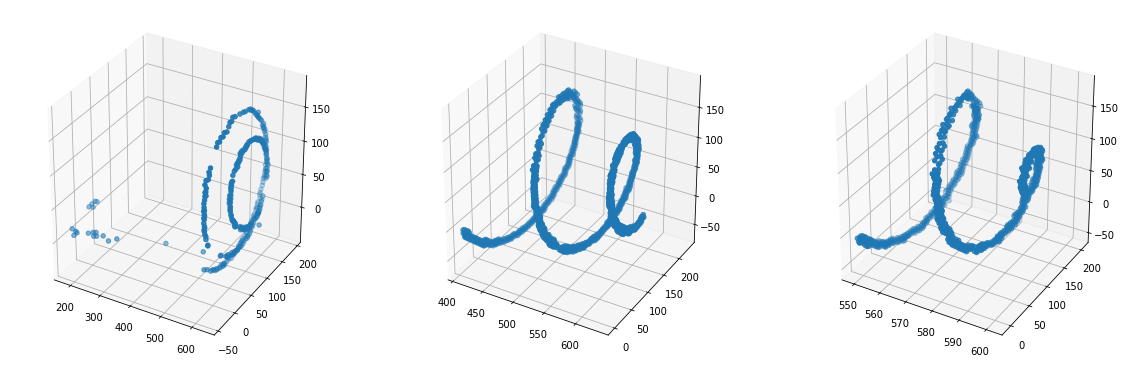

In [121]:
%matplotlib inline
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.')
plt.title("Differential Evolution")
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])


<IPython.core.display.Javascript object>


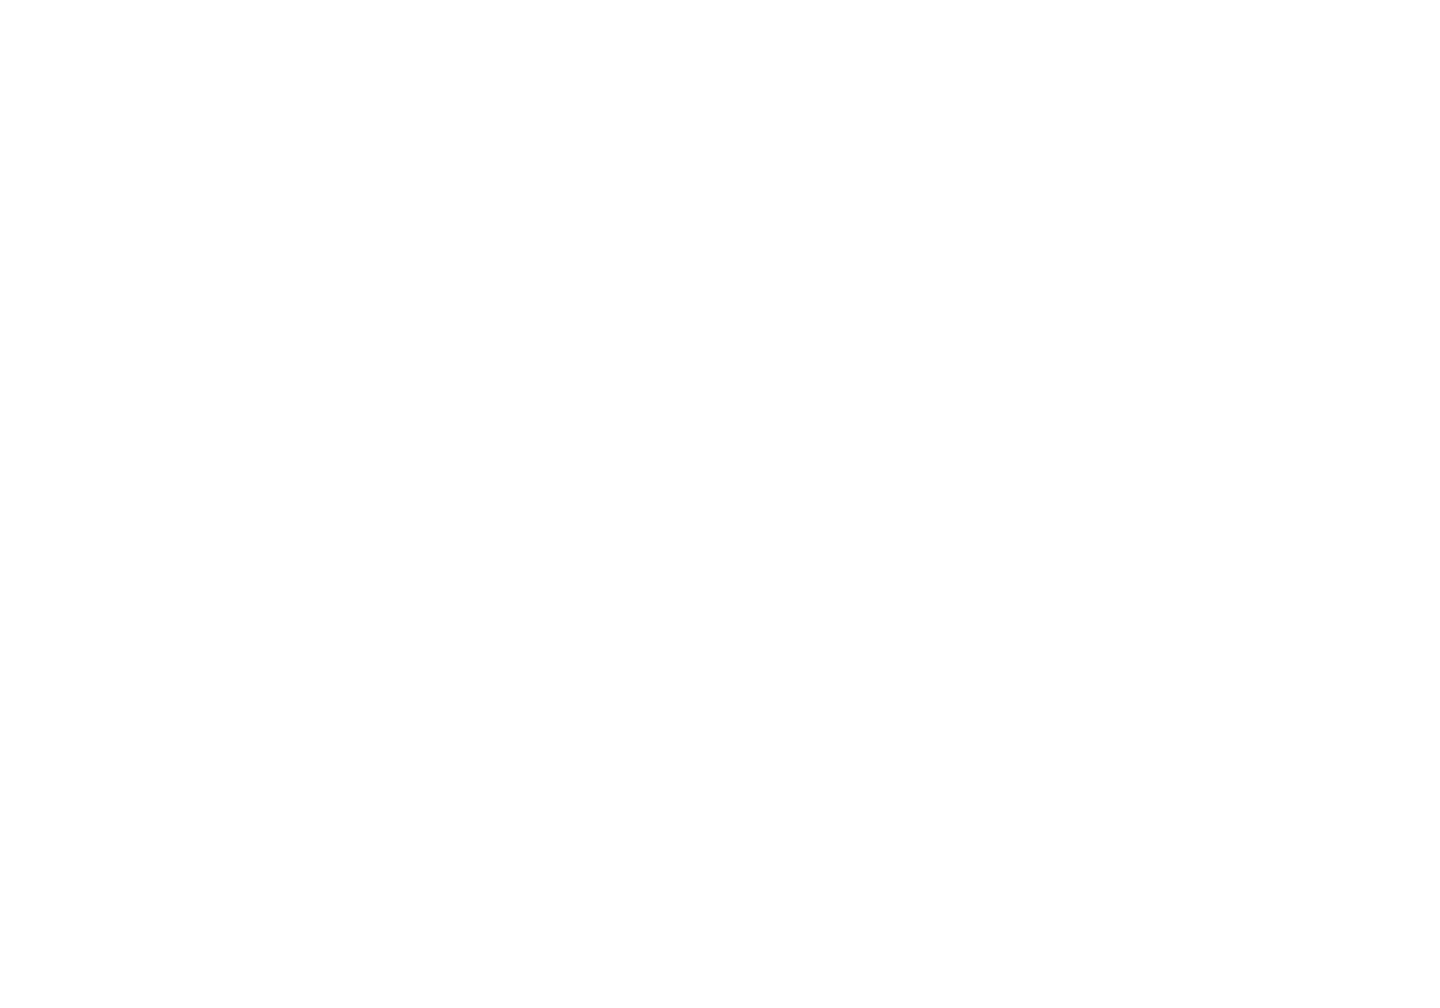

<IPython.core.display.Javascript object>


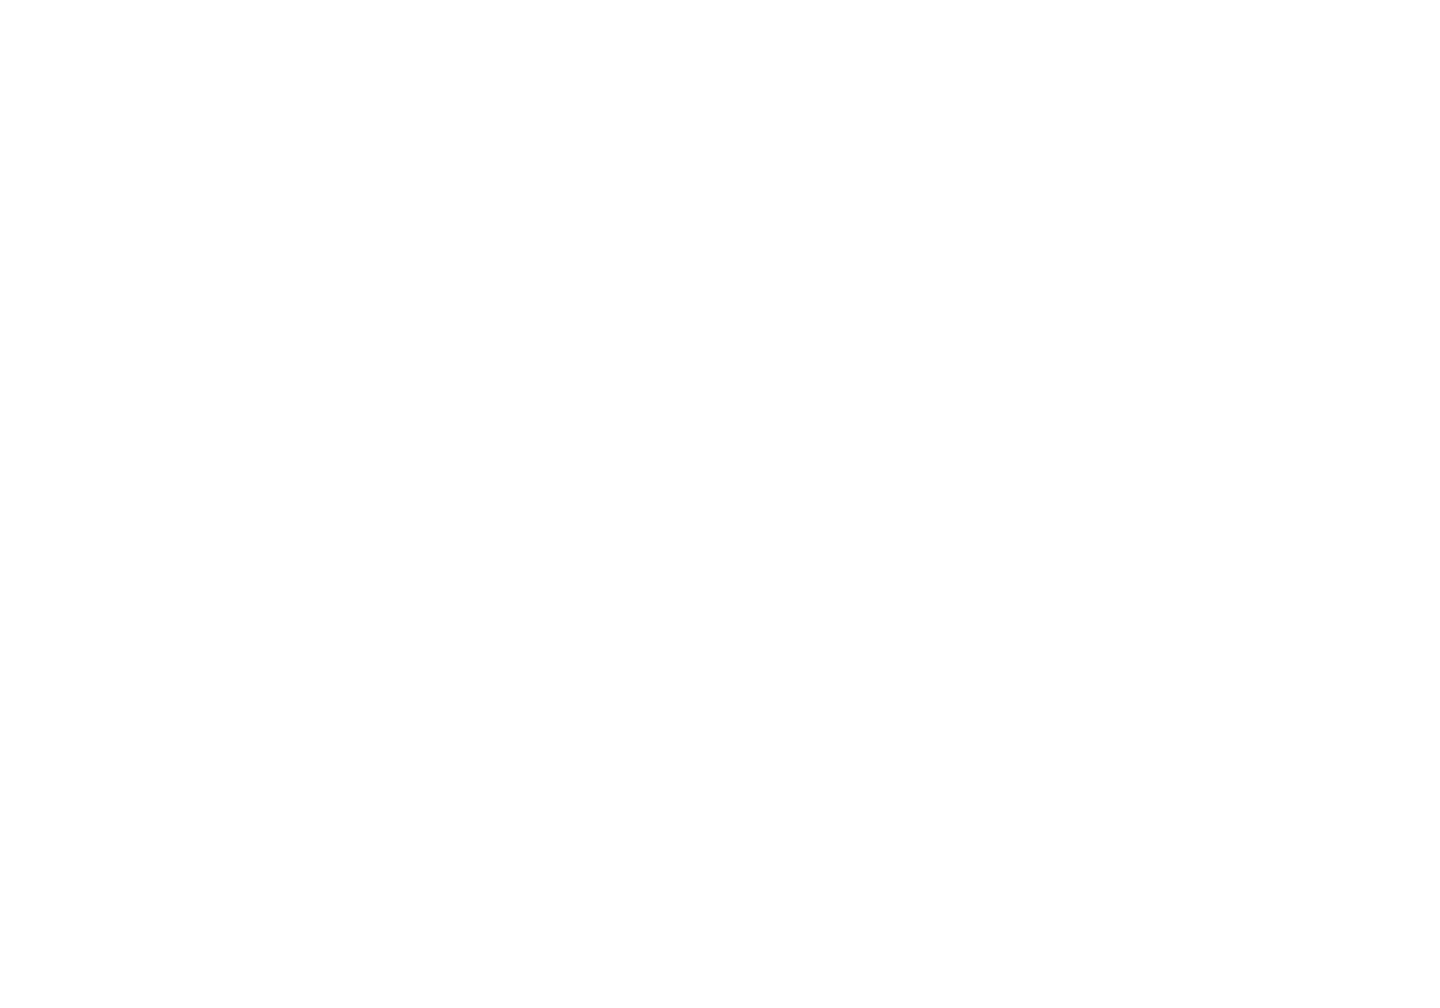

In [122]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5],c='r')
ax.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5],c='b')
ax.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5],c='g')

In [148]:
i = 1
def callbackF(x, f, accept):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f))
    i += 1

In [159]:
%%time
bh_nm_results = scipy.optimize.basinhopping(f,ctr0, callback=callbackF, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "Powell"})

  26 0.001541-0.001117 1.421071 5.562609-5.389049 3.418265 87.602225
  27 0.000257 0.003833 0.525080 1.182643-3.776183 1.305507 74.824413
  28 0.002445 0.003708 0.522000 1.226073-3.718842 1.313277 73.399112
  29 0.002707 0.003654 0.528403 1.255499-3.702262 1.338282 71.157844
  30 0.003548 0.004164 0.511182 1.260870-3.671022 1.292662 75.685769
  31 0.002917 0.003830 0.529355 1.248047-3.712307 1.337918 71.467964
  32 0.003424 0.005696 0.537622 1.368015-3.699201 1.381878 68.464222
  33 0.003285 0.003784 0.526042 1.317606-3.682123 1.344811 70.709557
  34 0.004174 0.004819 0.528403 1.357360-3.663567 1.358316 69.772286
  35 0.003757 0.005477 0.533843 1.377127-3.684012 1.374145 68.522949
  36 0.001529 0.003880 0.549010 1.420096-3.682254 1.414695 69.145849
  37 0.003557 0.006224 0.539665 1.385783-3.712740 1.389748 68.304206
  38 0.002281 0.003779 0.546879 1.342456-3.706575 1.401178 69.537530
  39 0.002310 0.004843 0.545553 1.412702-3.677974 1.406827 68.182127
  40 0.002787 0.004964 0.544909 1.

In [160]:
j = 1
def cut_callbackF(x, f, accept):
    global j
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(j,x[0],x[1],x[2],x[3],x[4],x[5],f))
    j += 1

In [162]:
%%time
cut_bh_nm_results = scipy.optimize.basinhopping(cut_f,cut_ctr0, callback=cut_callbackF, niter=25, T=0.01, stepsize=0.05, minimizer_kwargs={"method": "SLSQP"})

  26 0.002493 0.001940 0.582501 1.357873-4.026277 1.494263 65.727772
  27 0.000260-0.007838 0.552001 2.049132-3.819329 1.520673 42.579986
  28-0.000000 0.000000 0.593763 2.076376-3.847854 1.471818 100.818404
  29 0.000312 0.000339 0.545828 2.137241-3.845791 1.513305 53.094999
  30-0.000001-0.000000 0.538860 2.094424-3.866850 1.521555 100.869843
  31 0.002502 0.001865 0.582518 1.358644-4.026641 1.494350 65.728574
  32 0.000788 0.001225 0.541992 1.444488-3.708345 1.393855 75.130788
  33-0.000005-0.000006 0.722059 2.003915-3.805707 1.463185 100.793674
  34-0.012363-0.013318 0.532200 2.069462-4.035907 1.496930 86.306055
  35 0.000477 0.001083 0.545734 2.108112-3.849066 1.512486 53.231884
  36-0.000000 0.000000 0.505620 2.048456-3.865778 1.543089 100.850238
  37 0.002499 0.002095 0.582544 1.358911-4.025841 1.494451 65.726947
  38 0.011291-0.017419 0.491627 2.062254-3.846073 1.446787 88.901699
  39 0.002816 0.002080 0.582638 1.352741-4.027124 1.494569 65.728116
  40-0.000001 0.000002 0.50204

In [163]:
bh_nm = bh_nm_results.x
cut_bh_nm = cut_bh_nm_results.x
print(bh_nm_results)
print(cut_bh_nm_results)

                        fun: 67.93918237793328
 lowest_optimization_result:    direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-3.96896628e-04,  1.28664077e-05, -1.91495909e-03,
         3.51959173e-04,  1.85671793e-05, -4.70563731e-03]])
     fun: 67.93918237793328
 message: 'Optimization terminated successfully.'
    nfev: 1113
     nit: 8
  status: 0
 success: True
       x: array([ 2.78739463e-03,  4.96382486e-03,  5.44908669e-01,

In [164]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(bh_nm[0], bh_nm[1], bh_nm[2], bh_nm[3], bh_nm[4], bh_nm[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values
cut_evtClean, cut_ctr = sim.make_event(cut_bh_nm[0], cut_bh_nm[1], cut_bh_nm[2], cut_bh_nm[3], cut_bh_nm[4], cut_bh_nm[5])
cut_pyevtClean = sim.convert_event(cut_evtClean)
cut_sim_xyzs = cut_pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
cut_sim_xy = cut_sim_xyzs[:, 0:2]
cut_sim_xy_C = np.ascontiguousarray(cut_sim_xy, dtype=np.double)
cut_sim_cx, cut_sim_cy = pytpc.cleaning.hough_circle(cut_sim_xy_C)
cut_sim_uvw, (cut_sim_cu, cut_sim_cv) = mcfitter.preprocess(cut_sim_xyzs[:, 0:5], center=(cut_sim_cx, cut_sim_cy), rotate_pads=True)
cut_sim_uvw_values = cut_sim_uvw.values

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


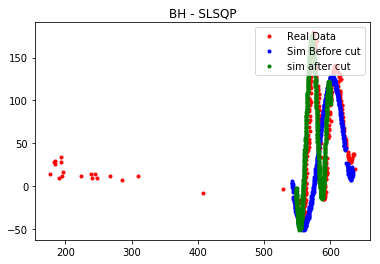

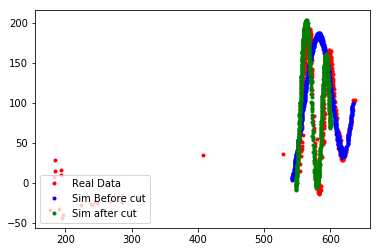

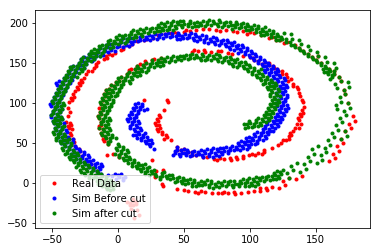

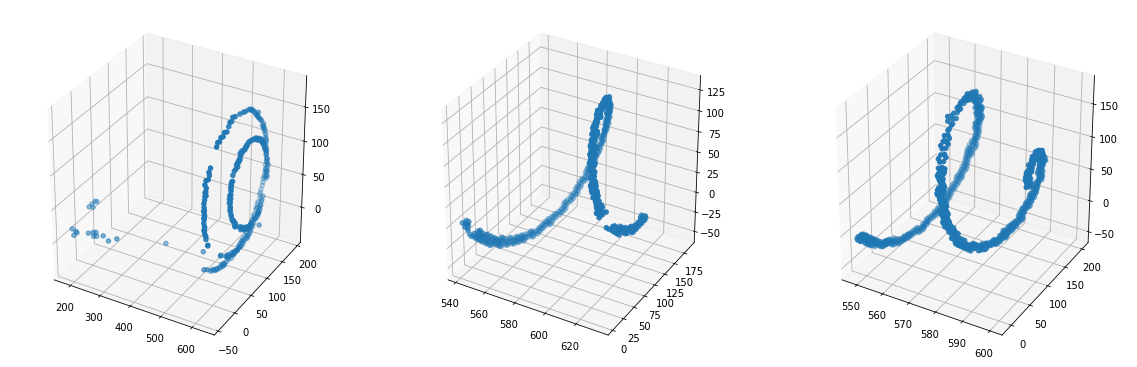

In [165]:
%matplotlib inline

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 5], 'g.', label='sim after cut')
plt.legend(loc=1)
plt.title("BH - SLSQP")
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 7], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Real Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.',label='Sim Before cut')
plt.plot(cut_sim_uvw_values[:, 5], cut_sim_uvw_values[:, 6], 'g.', label='Sim after cut')
plt.legend(loc=3)
plt.show()

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cut_sim_uvw_values[:,7],cut_sim_uvw_values[:,6],cut_sim_uvw_values[:,5])